# RateAndHalfSat - extended
Nutrient comparisons with edited dataset using surface instead of 2m for depth. (

In [19]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
import matplotlib.cm as cm
import matplotlib.patches as patches
%matplotlib inline

In [49]:
plt.style.use('/ocean/vdo/MEOPAR/biomodelevalpaper/bioModelEvalPaper.mplstyle')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [3]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, 
                                                    land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [4]:
nutrients_2015.shape

(890, 13)

In [5]:
model_nutrients = sorted(glob.glob(
    '/data/vdo/MEOPAR/completed-runs/RateAndHalfSat/test*/SalishSea*1d*ptrc*'))

In [6]:
with nc_tools.scDataset(model_nutrients) as f: #takes a while to run, prone to killing kernal
    times = f.variables['time_counter'][:]
    print('times is done')
    model_si = f.variables['silicon'][:, :19, ...]
    print('Si is done')
    model_n023 = f.variables['nitrate'][:, :19, ...]
    print('Nitrate is done')

times is done
Si is done
Nitrate is done


In [7]:
h = nc.Dataset(model_nutrients[0])

In [8]:
# convert into datetime
converted_timesa = nc.num2date(times, h.variables['time_counter'].units)

In [9]:
converted_timesa[0]

datetime.datetime(2015, 2, 1, 12, 0)

In [10]:
converted_timesa[-1]

datetime.datetime(2015, 9, 28, 12, 0)

In [11]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(890)])
dates = np.ma.masked_outside(dates, converted_timesa[0], 
                             converted_timesa[-1])
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

In [12]:
np.ma.count(cs_si)

756

In [15]:
list_of_model_si = np.ma.masked_array(np.zeros((890)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((890)), mask = True)
t = 0
for n in range(890):
    if dates.mask[n] == False:
        Yind = int(Yinds[n])
        Xind = int(Xinds[n])
        date = dates[n]
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 18,Yind, Xind]
            n_val = model_n023[index, 18, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
        if ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 0,Yind, Xind]
            n_val = model_n023[index, 0, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
    t = t + 1

In [16]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [17]:
np.ma.count(cs_no23)

745

In [18]:
np.ma.count(list_of_model_ni)

745

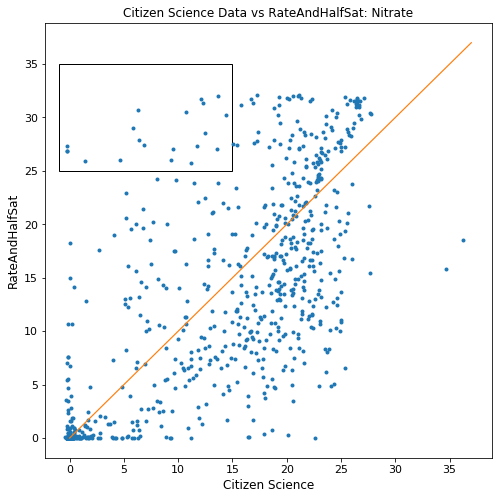

In [50]:
fig, ax = plt.subplots(figsize = (8,8))
colours = cm.rainbow(np.linspace(0,1,8))
ax.plot(cs_no23, list_of_model_ni, '.')

ax.plot(np.arange(0,38), np.arange(0,38), '-')
ax.set_title('Citizen Science Data vs RateAndHalfSat: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('RateAndHalfSat')
ax.add_patch(
    patches.Rectangle(
        (-1, 25),   # (x,y)
        16,          # width
        10,          # height
    fill = False)
);

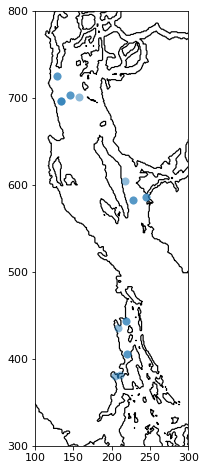

In [51]:
fig, ax = plt.subplots(figsize = ((12,8)))
ax.plot(Xinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
        Yinds[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 'o', alpha = 0.5)
viz_tools.set_aspect(ax)
ax.set_xlim(100, 300)
ax.set_ylim(300, 800)
viz_tools.plot_coastline(ax, grid);

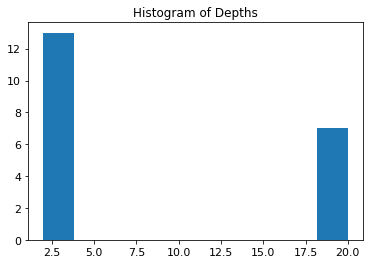

In [52]:
plt.hist(depths[(cs_no23 <= 15) & (list_of_model_ni >= 25)]);
plt.title('Histogram of Depths');

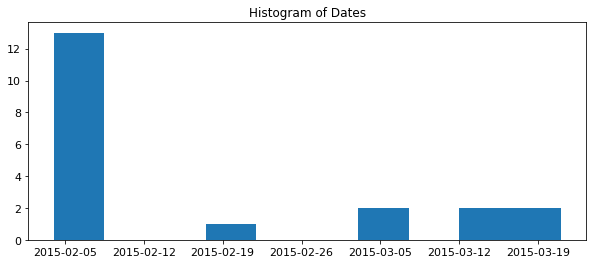

In [53]:
fig, ax = plt.subplots(figsize = (10,4))
ax.hist(dates[[(cs_no23 <= 15) & (list_of_model_ni >= 25)]])
ax.set_title('Histogram of Dates');

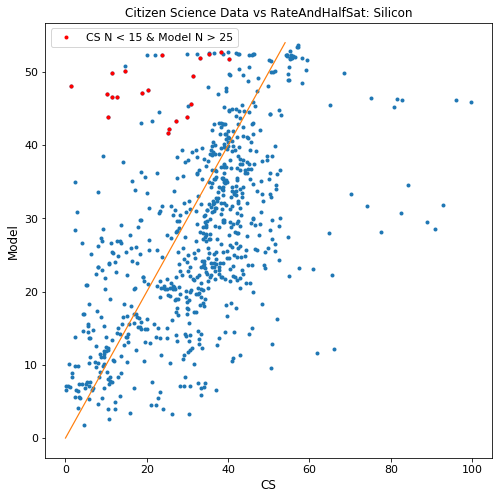

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, '.');
ax.plot(np.arange(0,55), np.arange(0,55), '-')
ax.plot(cs_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
        list_of_model_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 'r.', label = 'CS N < 15 & Model N > 25')
ax.legend()
ax.set_title('Citizen Science Data vs RateAndHalfSat: Silicon')
ax.set_xlabel('CS')
ax.set_ylabel('Model');

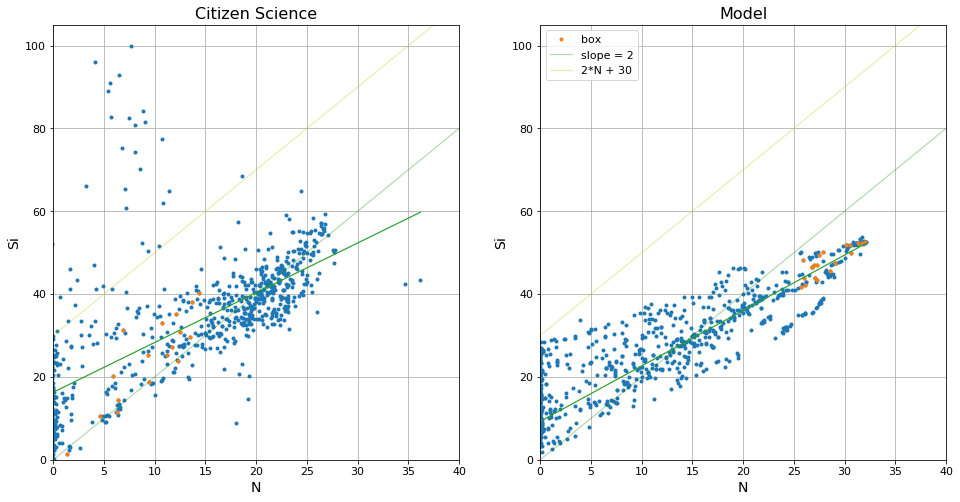

In [55]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23, cs_si, '.')
ax[0].plot(cs_no23[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
           cs_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], '.')
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)

ax[1].plot(list_of_model_ni, list_of_model_si, '.')
ax[1].plot(list_of_model_ni[(cs_no23 <= 15) & (list_of_model_ni >= 25)], 
           list_of_model_si[(cs_no23 <= 15) & (list_of_model_ni >= 25)], '.', label = 'box')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')

ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();